In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.bencmark = True
plt.ion()

# Load Data

In [2]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip -P data && cd data && unzip hymenoptera_data.zip

--2025-02-26 22:14:47--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving download.pytorch.org (download.pytorch.org)... 2600:9000:2549:a00:d:607e:4540:93a1, 2600:9000:2549:9e00:d:607e:4540:93a1, 2600:9000:2549:1a00:d:607e:4540:93a1, ...
Connecting to download.pytorch.org (download.pytorch.org)|2600:9000:2549:a00:d:607e:4540:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘data/hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  26.6MB/s    in 1.7s    

2025-02-26 22:14:54 (26.6 MB/s) - ‘data/hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  infla

In [3]:
# Determine the device to be used for computation (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data transformation pipelines for training and validation datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Randomly crop the image to 224x224 pixels
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.ToTensor(),  # Convert the image to a Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet means and stds
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),  # Resize the image to 256x256 pixels
        transforms.CenterCrop(224),  # Crop the center of the image to 224x224 pixels
        transforms.ToTensor(),  # Convert the image to a Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet means and stds
    ])
}

# Set the data directory containing the training and validation datasets
data_dir = 'data/hymenoptera_data'

# Create datasets for training and validation, applying the respective data transformations
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']
}

# Create DataLoaders for training and validation datasets for batching and shuffling
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],  # Dataset to load
        batch_size=4,  # Number of samples per batch
        shuffle=True,  # Shuffle data at every epoch
        num_workers=(os.cpu_count() if device.type == 'cpu' else min(os.cpu_count(), 4))
        # Number of workers for data loading
    ) for x in ['train', 'val']
}

# Calculate the size of each dataset (number of samples)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Get the class names from the training dataset
class_names = image_datasets['train'].classes

print(f'Using {device} device')  # Output the chosen device

Using cuda device


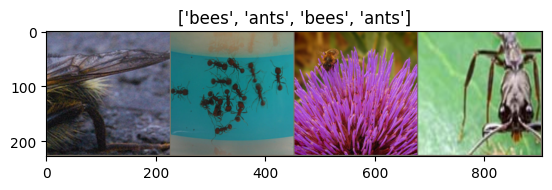

In [4]:
# Define a function to display an image from a Tensor
def imshow(inp, title=None):
    """Display image for Tensor."""
    # Convert the input Tensor to a NumPy array and transpose it for visualization
    inp = inp.numpy().transpose((1, 2, 0))

    # Define the mean and standard deviation used for normalization
    # These values ([0.485, 0.456, 0.406] for mean and [0.229, 0.224, 0.225] for standard deviation)
    # are derived from the ImageNet dataset. They represent the statistical properties
    # of the pixel intensity distribution across the entire ImageNet dataset:
    # - The mean values correspond to the average pixel intensity for red, green, and blue channels, respectively.
    # - The standard deviation values correspond to how much pixel intensities vary from the mean for each channel.
    # Normalizing the input data using these values ensures that the data is centered around zero
    # (zero-centered) and scaled to unit variance (standardized). This is crucial when using models pre-trained
    # on ImageNet, as it ensures compatibility between the input data and the model's learned parameters.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Denormalize the image by reversing the normalization
    # This restores the image from its normalized form to its original range for visualization.
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)  # Clip values to ensure they're within the valid range [0, 1]

    # Display the image using matplotlib
    plt.imshow(inp)
    if title is not None:
        plt.title(title)  # Set the title for the image if provided
    plt.pause(0.001)  # Pause a bit to ensure the plots are updated


# Get a batch of training data from the DataLoader
inputs, classes = next(iter(dataloaders['train']))

# Create a grid of images from the batch for visualization
out = torchvision.utils.make_grid(inputs)

# Display the grid of images along with their class names
imshow(out, title=[class_names[x] for x in classes])

### **Purpose:** Why normalize image data?
1. **Preprocessing Step Before Feeding Into a Neural Network**:
    - Most computer vision models (especially pre-trained models like those in torchvision—ResNet, VGG, etc.) expect images to be **standardized** (normalized to a defined range/distribution) so that:
        - The inputs to the neural network remain consistent.
        - Variations in brightness, contrast, or overall scale across different datasets are reduced.

    - Normalizing each channel (R, G, B) using predefined statistical values ensures that the inputs match the assumptions of the pre-trained model during training or inference.

2. **Channel Normalization for RGB Images**:
    - Images have three channels (Red, Green, and Blue), each with its own range of pixel intensities (typically 0–255 for standard RGB images).
    - Normalization rescales this range to a **mean of 0** and a **unit variance** (or to values close to them). The normalization formula is:
``` python
normalized_pixel = (pixel - mean) / std
```
- `mean`: Adjusts (shifts) the pixel values to center the data distribution around zero.
- `std`: Scales the pixel values, ensuring they follow the same range (or spread).

### **Where do the `mean` and `std` values come from?**
1. **Derived from the ImageNet Dataset**:
    - The values `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]` are computed from the statistics of images in the **ImageNet dataset**.
    - ImageNet is a widely used benchmark dataset for training large-scale models. It contains millions of natural images with diverse content (animals, objects, plants, etc.).
    - The **mean** and **standard deviation** values are computed across all training images in ImageNet for each channel (Red, Green, and Blue) by taking the pixel averages and their standard deviations.

2. **What These Values Represent**:
    - **Mean Values (`[0.485, 0.456, 0.406]`)**:
        - These represent the average pixel intensity for each channel (R, G, B) across all images in the ImageNet dataset, normalized to a range between 0 and 1. For example:
            - Red channel: On average, red pixel values are approximately 0.485 in normalized data.
            - Green channel: Mean intensity is 0.456.
            - Blue channel: Mean intensity is 0.406.

    - **Standard Deviation (`[0.229, 0.224, 0.225]`)**:
        - These values indicate how much pixel intensity varies (or spreads out) from the average for each channel.
        - For example:
            - Red channel: A standard deviation of 0.229 means that the pixel intensities in the red channel deviate by 0.229 on average from the mean value of 0.485.

### **Why Use ImageNet Statistics?**
1. **Pretrained Models Use the Same Values**:
    - Models pre-trained on ImageNet (e.g., ResNet, VGG, etc.) expect input images to be normalized using the same `mean` and `std` values because the model weights were trained with this normalization during their original training on ImageNet.

2. **Consistency Across Different Datasets**:
    - Even if the dataset isn't ImageNet, normalizing the data using these mean and std values helps maintain consistency when using general-purpose pre-trained models.

3. **Better Convergence and Numerical Stability**:
    - Centering the data around zero and ensuring unit variance (or close to it) avoids issues like:
        - Activation functions (e.g., ReLU, sigmoid) saturating unevenly due to unnormalized inputs.
        - Gradients exploding or vanishing during training because of large or inconsistent input values.

### **Example: Without Normalization**
If the images are not normalized:
1. A typical pixel value in an RGB image might range from **0 to 255**.
2. Deep networks process these images at their pixel-level input, and the large range could make optimization difficult:
    - For example, weights may require higher precision to account for larger input values.
    - Activations might become unreasonably large, and gradients could blow up.

### **How Normalization with These Values Works**
When you apply the `transforms.Normalize(mean, std)` operation during preprocessing:
1. Each pixel value in the image is first scaled to the range **[0, 1]** (via `ToTensor()`).
2. Then, **channel-wise normalization** is applied using the ImageNet-specific mean and std:
``` python
normalized_pixel = (pixel - mean) / std
```
For example:
- Suppose:
```
     Red_pixel = 0.6, Green_pixel = 0.5, Blue_pixel = 0.45
```
- Normalization:
```
     Normalized_Red = (0.6 - 0.485) / 0.229 ≈ 0.502
     Normalized_Green = (0.5 - 0.456) / 0.224 ≈ 0.196
     Normalized_Blue = (0.45 - 0.406) / 0.225 ≈ 0.196
```
### **Benefits of Using ImageNet `mean` and `std`**
- **Pretrained Compatibility**: Your input data matches the distribution of the data used to train the model (ImageNet).
- **Better Training Stability**: Model weights don't have to account for variances in pixel intensity ranges, improving optimization.
- **Consistent Outputs**: Models provide reliable outputs across datasets when inputs are comparable to the training data distribution.


In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()  # Record the start time of training

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        # Define the path for saving the model parameters
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)  # Save initial model state
        best_acc = 0.0  # Initialize the best accuracy to zero

        # Loop over each epoch
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')  # Print current epoch
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluation mode

                running_loss = 0.0  # Reset running loss for the current phase
                running_corrects = 0  # Reset running correct predictions count

                # Iterate over batches of data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)  # Move inputs to the appropriate device (CPU/GPU)
                    labels = labels.to(device)  # Move labels to the appropriate device

                    optimizer.zero_grad()  # Clear gradients of the optimizer

                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):  # Enable gradient calculation in training phase
                        outputs = model(inputs)  # Get model outputs
                        _, preds = torch.max(outputs, 1)  # Get predicted classes
                        loss = criterion(outputs, labels)  # Compute loss

                        # Backward pass and optimizer step for training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Accumulate loss and correct predictions
                    running_loss += loss.item() * inputs.size(0)  # Multiply loss by batch size
                    running_corrects += torch.sum(preds == labels.data)  # Count correct predictions

                if phase == 'train':
                    scheduler.step()  # Step the learning rate scheduler

                # Compute epoch loss and accuracy
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')  # Print metrics for the epoch

                # Save the best model parameters if validation accuracy improves
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()  # Print a blank line to separate epochs

        # Calculate and display the total training time
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')  # Print the best validation accuracy

        # Load the model parameters of the best model
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model  # Return the trained model

# Visualize Model Predictions

In [6]:
def visualize_model(model, num_images=6):
    # Save the model's current training mode to restore it later
    was_training = model.training

    # Set the model to evaluation mode (disables dropout, batch norm, etc.)
    model.eval()
    images_so_far = 0  # Track the number of images displayed
    fig = plt.figure()  # Create a new figure for the images

    with torch.no_grad():  # Disable gradient computation for faster execution
        for i, (inputs, labels) in enumerate(dataloaders['val']):  # Loop over validation data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the appropriate device

            # Get model predictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the predicted class indices

            # Loop through the batch and display each image
            for j in range(inputs.size()[0]):
                images_so_far += 1  # Increment the image counter
                ax = plt.subplot(num_images // 2, 2, images_so_far)  # Add a subplot for the image
                ax.axis('off')  # Disable axis
                ax.set_title(f'predicted: {class_names[preds[j]]}')  # Set the title to show the prediction
                imshow(inputs.cpu().data[j])  # Display the image

                # Stop once the desired number of images have been displayed
                if images_so_far == num_images:
                    model.train(mode=was_training)  # Restore the original training mode
                    return
        # Restore the original training mode after processing all data
        model.train(mode=was_training)

# Finetuning the ConvNet

In [7]:
# Load the ResNet-18 model pre-trained on the ImageNet dataset
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# Extract the number of features in the final fully connected layer
num_ftrs = model_ft.fc.in_features

# Replace the fully connected layer with a new one for binary classification (2 classes: ants, bees)
# Alternatively, len(class_names) can generalize the output layer based on the dataset
model_ft.fc = nn.Linear(num_ftrs, 2)

# Move the model to the appropriate device (CPU or GPU)
model_ft = model_ft.to(device)

# Define the loss function as CrossEntropyLoss, typically used for classification tasks
criterion = nn.CrossEntropyLoss()

# Use the SGD (Stochastic Gradient Descent) optimizer for training
# It optimizes all the parameters of the model
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Define a learning rate scheduler to decay the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/leviathan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 28.4MB/s]


1. **`lr_scheduler.StepLR`**:
    - This method is used to adjust the learning rate of an optimizer during training at regular intervals, specifically in steps (hence, "step scheduler").
    - It reduces the learning rate of the optimizer by a fixed factor (`gamma`) every `step_size` epochs.

2. **Parameters in the code**:
    - `optimizer_ft`:
        - This is the optimizer (often created with `torch.optim` like `SGD` or `Adam`) whose learning rate will be adjusted by the `StepLR` scheduler.

    - `step_size=7`:
        - This means the learning rate will change every **7 epochs**. After **every 7 epochs**, the `StepLR` scheduler will reduce the learning rate by the specified multiplier.

    - `gamma=0.1`:
        - This parameter defines the factor by which the learning rate is multiplied at each step. For example, if the current learning rate of the optimizer is `0.01`, after 7 epochs, it will be decreased by multiplying it with `gamma (0.1)`, resulting in a new learning rate of `0.001`.

3. **Usage**:
    - In deep learning, it's common to adjust the learning rate during training to improve convergence and avoid overshooting the optimal solution. A scheduler like `StepLR` helps automate this process.

4. **Effect**:
    - If you use this scheduler in your training loop, the learning rate will remain constant for 7 epochs and then drop to 10% (factor `0.1`) of its current value every 7 epochs.

### Example:
If the initial learning rate is `0.01`, the progression of learning rates with `step_size=7` and `gamma=0.1` would look like this:
- Epochs 1–7: learning rate = `0.01`
- Epochs 8–14: learning rate = `0.001`
- Epochs 15–21: learning rate = `0.0001`
- And so on...


# Train and evaluate

In [8]:
from datetime import datetime  # Import module to track training start and end times

start_time = datetime.now()  # Record the start time
print(f"Training started at: {start_time}")

# Train the model with a pre-defined number of epochs (25 in this case)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

end_time = datetime.now()  # Record the end time
print(f"Training ended at: {end_time}")

# Calculate and display the total training duration
print(f"Training duration: {end_time - start_time}")

Training started at: 2025-02-26 22:15:36.333770
Epoch 0/24
----------
train Loss: 0.4763 Acc: 0.7377
val Loss: 0.3129 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.6335 Acc: 0.7705
val Loss: 0.3792 Acc: 0.8627

Epoch 2/24
----------
train Loss: 0.4869 Acc: 0.8279
val Loss: 0.2832 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.5911 Acc: 0.7377
val Loss: 0.3105 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.3452 Acc: 0.8484
val Loss: 0.3298 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.4160 Acc: 0.8525
val Loss: 0.5422 Acc: 0.8366

Epoch 6/24
----------
train Loss: 0.5854 Acc: 0.8074
val Loss: 0.5481 Acc: 0.8562

Epoch 7/24
----------
train Loss: 0.4802 Acc: 0.7910
val Loss: 0.4258 Acc: 0.8562

Epoch 8/24
----------
train Loss: 0.3096 Acc: 0.8852
val Loss: 0.3663 Acc: 0.8889

Epoch 9/24
----------
train Loss: 0.4100 Acc: 0.8402
val Loss: 0.3134 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2504 Acc: 0.8852
val Loss: 0.3467 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.3

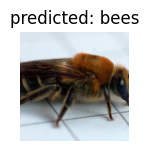

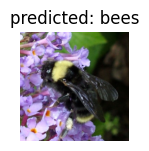

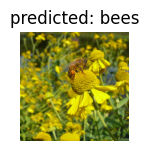

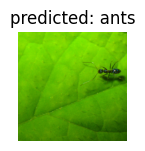

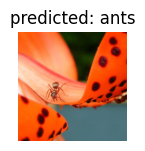

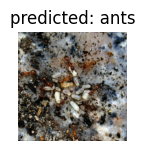

In [9]:
# Visualize the model predictions for the trained model
# This will display a few images along with their predicted labels
visualize_model(model_ft)

# ConvNet as fixed feature extractor

In [10]:
# Load a pretrained ResNet-18 model, using weights trained on the ImageNet dataset
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Freeze all the parameters in the model (no gradients will be computed for them)
for param in model_conv.parameters():
    param.requires_grad = False

# Modify the fully connected layer to adapt it for binary classification (ants and bees)
# Extract the number of features in the original fully connected layer
num_ftrs = model_conv.fc.in_features
# Replace the fully connected layer with a new one having 2 output classes
model_conv.fc = nn.Linear(num_ftrs, 2)

# Move the model to the appropriate computation device (CPU or GPU)
model_conv = model_conv.to(device)

# Define the loss function for the model, CrossEntropyLoss is suitable for classification tasks
criterion = nn.CrossEntropyLoss()

# Set up the optimizer to only optimize the parameters of the newly added fully connected layer
# Use Stochastic Gradient Descent (SGD) with a learning rate of 0.001 and momentum of 0.9
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Define a learning rate scheduler that decays the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

###
- **`model_conv.parameters()`**: This retrieves an iterator over all the parameters (weights and biases) of a neural network model stored in the object `model_conv`. These parameters represent the learnable parts of the model.
- **`param.requires_grad` **: This is an attribute of each parameter in PyTorch. When `requires_grad` is set to `True`, it means that PyTorch will compute and store gradients for that parameter during the backward pass (training). These gradients are necessary for optimizing the parameters (i.e., updating them via gradient descent). If it's set to `False`, PyTorch skips gradient computation for that parameter.
- **`param.requires_grad = False` **: This line disables gradient computation for all the parameters in `model_conv`. By doing this, the parameters are effectively **frozen**, which means:
    - They will not be updated during training.
    - Their existing values (from pre-training) will remain unchanged.

### Purpose
This code is likely used during **transfer learning** or **fine-tuning**, where:
1. A pre-trained model (like ResNet, VGG, etc.) has already learned generic features from a large dataset (e.g., ImageNet).
2. You want to freeze the learned layers (parameters) to prevent them from being updated during training.
3. This is done to focus training on modifying or adding new layers (such as a custom classification head) without altering the pre-trained features.

### Example
If `model_conv` is a pre-trained convolutional network from PyTorch (like ResNet):
``` python
import torchvision.models as models

# Load a pre-trained model
model_conv = models.resnet18(pretrained=True)

# Freeze all layers
for param in model_conv.parameters():
    param.requires_grad = False

# Replace the final classification layer (e.g., for a new task with different output classes)
import torch.nn as nn

num_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, 10)  # Modify output layer to 10 classes
```
In this example:
- The pre-trained layers of the ResNet (`model_conv`) are frozen.
- Only the new classification layer (`model_conv.fc`) will learn during training.

By freezing parameters, you save computational resources and training time while


# Train and evaluate

In [11]:
# Train the ResNet model (model_conv) as a fixed feature extractor.
# Using criterion for loss calculation, optimizer_conv for optimizing only the unfrozen layers, 
# and exp_lr_scheduler for adjusting the learning rate during training.
# The model is trained for 25 epochs.
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4938 Acc: 0.7746
val Loss: 0.2345 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.4081 Acc: 0.8074
val Loss: 0.1929 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.4095 Acc: 0.7869
val Loss: 0.1597 Acc: 0.9608

Epoch 3/24
----------
train Loss: 0.4162 Acc: 0.8156
val Loss: 0.1768 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4341 Acc: 0.8279
val Loss: 0.1705 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.4843 Acc: 0.7869
val Loss: 0.1609 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.3344 Acc: 0.8566
val Loss: 0.1929 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.4644 Acc: 0.7992
val Loss: 0.1792 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3429 Acc: 0.8443
val Loss: 0.1587 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3347 Acc: 0.8402
val Loss: 0.1683 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.2797 Acc: 0.8893
val Loss: 0.1680 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.3344 Acc: 0.8648
val Loss: 0.1642 Acc: 0.9542

Ep

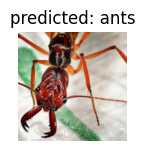

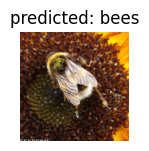

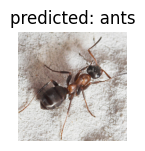

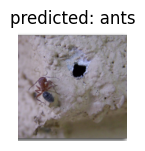

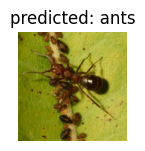

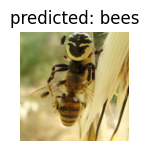

In [12]:
# Visualize the predictions of the trained model on a set of validation images
visualize_model(model_conv)

# Turn off interactive mode to ensure plots remain visible
plt.ioff()

# Display the plot for model predictions
plt.show()

# Inference on custom images

In [13]:
def visualize_model_predictions(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path).convert('RGB')  # Ensure input image has 3 channels
    img = data_transforms['val'](img).unsqueeze(0).to(device)  # Apply transformation and add batch dimension

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        plt.figure(figsize=(6, 6))  # Dynamically create a figure for the single image
        ax = plt.gca()  # Get the current Axes instance
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds.item()]}')  # Use .item() for Tensor compatibility
        imshow(img.cpu().squeeze(0))  # Remove batch dimension before visualization

        model.train(mode=was_training)

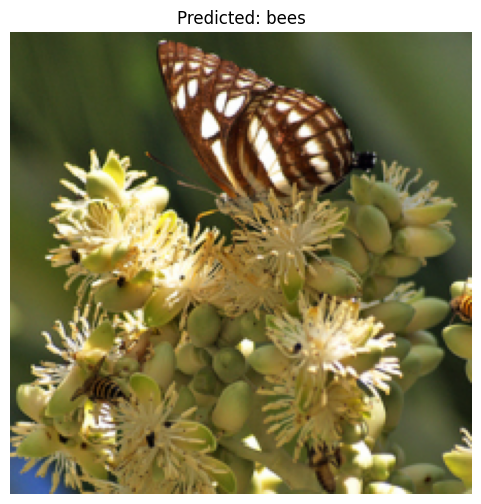

In [14]:
import os

try:
    img_path = 'data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'

    # Check if the specified image file exists
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image file not found: {img_path}")

    # Ensure the file has a valid image extension
    if not img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        raise ValueError(f"Provided file is not a valid image: {img_path}")

    visualize_model_predictions(model_conv, img_path=img_path)

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    plt.ioff()
    plt.show()